# 🗳️ Prédiction des Élections Présidentielles - Validation Temporelle

## 🎯 Objectif
Ce notebook compare deux approches de validation pour prédire les résultats d'élections présidentielles :
- ❌ **Validation aléatoire** (problématique) : mélange des années
- ✅ **Validation temporelle** (recommandée) : entraînement sur le passé, test sur le futur

## 📊 Données
- **Années** : 1995, 2002, 2007, 2012, 2017, 2022
- **Variables** : Taux criminalité, chômage, défaillances entreprises, clivage politique
- **Cible** : Gagnant tour 1 et tour 2 par département

## ⚠️ Problème de la validation aléatoire
La validation aléatoire peut entraîner le modèle sur 2022 et le tester sur 1995, ce qui n'a aucun sens pour une prédiction électorale !

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

Gagnant tour 1:

📊 Aperçu des données disponibles:
Années disponibles: [np.int64(1995), np.int64(2002), np.int64(2007), np.int64(2012), np.int64(2017), np.int64(2022)]
Nombre total d'observations: 350
Départements: 5

🎯 VALIDATION TEMPORELLE - Prédiction Tour 1
📚 Entraînement sur: [1995, 2002, 2007, 2012, 2017] (290 observations)
🧪 Test sur: 2022 (60 observations)
🎯 Précision validation temporelle: 0.92

🔄 VALIDATION CROISÉE TEMPORELLE
📅 Entraînement: [np.int64(1995), np.int64(2002), np.int64(2007), np.int64(2012), np.int64(2017)] → Test: 2022 → Précision: 0.92

📈 Précision moyenne validation croisée temporelle: 0.92 ± 0.00

⚡ COMPARAISON AVEC VALIDATION ALÉATOIRE
🎲 Précision validation aléatoire: 0.90
🎯 Précision validation temporelle: 0.92
📊 Différence: 0.02
✅ La validation temporelle est plus réaliste pour ce type de prédiction.

🔍 IMPORTANCE DES VARIABLES (Modèle temporel)
Taux criminalite: 0.0402
Taux chomage: 0.1144
Nombre defaillance entreprise: 0.1346
Centre: 0.1052
Droite: 0.3309
Extrême droit

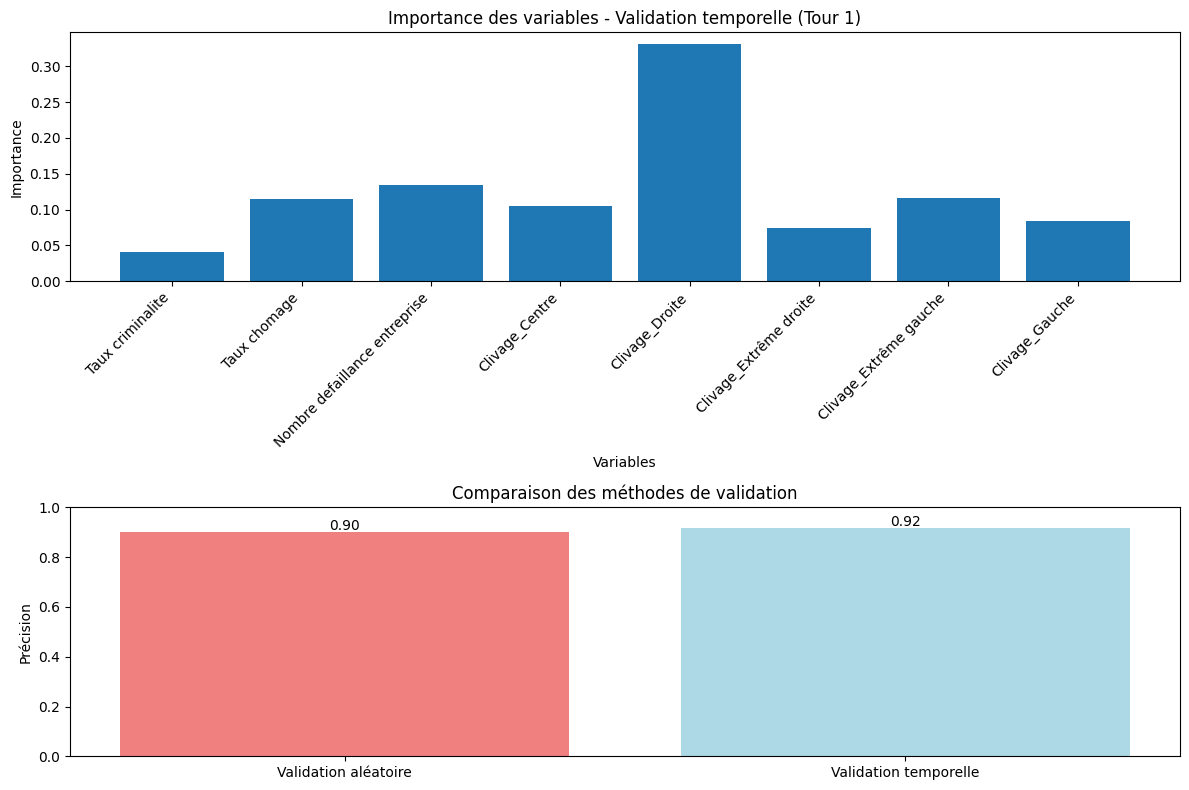

In [2]:
# Chargement des données avec le bon chemin
df = pd.read_csv("../fusioned_data/results_by_year.csv", sep=",")

print("📊 Aperçu des données disponibles:")
print(f"Années disponibles: {sorted(df['Année'].unique())}")
print(f"Nombre total d'observations: {len(df)}")
print(f"Départements: {df['Libellé du département'].nunique()}")

# Encodage One-Hot pour 'Clivage'
one_hot = OneHotEncoder()
clivage_encoded = one_hot.fit_transform(df['Clivage'].values.reshape(-1,1)).toarray()
categories = one_hot.categories_[0]
clivage_df = pd.DataFrame(clivage_encoded, columns = ["Clivage_"+str(category) for category in categories])
df = pd.concat([df, clivage_df], axis=1)

# APPROCHE 1: Validation temporelle (plus pertinente)
print("\n🎯 VALIDATION TEMPORELLE - Prédiction Tour 1")
print("="*50)

# Entraînement sur les années 1995-2017, test sur 2022
train_years = [1995, 2002, 2007, 2012, 2017]
test_year = 2022

df_train = df[df['Année'].isin(train_years)]
df_test = df[df['Année'] == test_year]

print(f"📚 Entraînement sur: {train_years} ({len(df_train)} observations)")
print(f"🧪 Test sur: {test_year} ({len(df_test)} observations)")

# Sélection des caractéristiques
feature_cols = ['Taux criminalite', 'Taux chomage', 'Nombre defaillance entreprise'] + list(clivage_df.columns)
X_train = df_train[feature_cols]
y_train = df_train['Gagnant tour 1']
X_test = df_test[feature_cols]
y_test = df_test['Gagnant tour 1']  # Correction: doit être 'Gagnant tour 1'

# Création et entraînement du modèle
model_temporal = RandomForestClassifier(random_state=42, n_estimators=100)
model_temporal.fit(X_train, y_train)

# Prédiction et évaluation
y_pred_temporal = model_temporal.predict(X_test)
accuracy_temporal = accuracy_score(y_test, y_pred_temporal)

print(f"🎯 Précision validation temporelle: {accuracy_temporal:.2f}")

# APPROCHE 2: Validation croisée temporelle (encore mieux)
print("\n🔄 VALIDATION CROISÉE TEMPORELLE")
print("="*50)

years = sorted(df['Année'].unique())
temporal_scores = []

for i in range(len(years)-1):
    train_years = years[:i+4] if i+4 < len(years) else years[:i+3]  # Prendre au moins 4 années pour l'entraînement
    if len(train_years) < 3:  # Minimum 3 années pour l'entraînement
        continue
    
    test_year = years[i+3] if i+3 < len(years) else years[-1]
    
    if test_year in train_years:
        continue
    
    df_train_cv = df[df['Année'].isin(train_years)]
    df_test_cv = df[df['Année'] == test_year]
    
    if len(df_test_cv) == 0:
        continue
    
    X_train_cv = df_train_cv[feature_cols]
    y_train_cv = df_train_cv['Gagnant tour 1']
    X_test_cv = df_test_cv[feature_cols]
    y_test_cv = df_test_cv['Gagnant tour 1']
    
    model_cv = RandomForestClassifier(random_state=42, n_estimators=100)
    model_cv.fit(X_train_cv, y_train_cv)
    
    y_pred_cv = model_cv.predict(X_test_cv)
    score = accuracy_score(y_test_cv, y_pred_cv)
    temporal_scores.append(score)
    
    print(f"📅 Entraînement: {train_years} → Test: {test_year} → Précision: {score:.2f}")

if temporal_scores:
    print(f"\n📈 Précision moyenne validation croisée temporelle: {np.mean(temporal_scores):.2f} ± {np.std(temporal_scores):.2f}")
else:
    print("⚠️ Pas assez de données pour la validation croisée temporelle")

# COMPARAISON avec l'approche originale (aléatoire)
print(f"\n⚡ COMPARAISON AVEC VALIDATION ALÉATOIRE")
print("="*50)

X_all = df[feature_cols]
y_all = df['Gagnant tour 1']
X_train_random, X_test_random, y_train_random, y_test_random = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42)

model_random = RandomForestClassifier(random_state=42, n_estimators=100)
model_random.fit(X_train_random, y_train_random)
y_pred_random = model_random.predict(X_test_random)
accuracy_random = accuracy_score(y_test_random, y_pred_random)

print(f"🎲 Précision validation aléatoire: {accuracy_random:.2f}")
print(f"🎯 Précision validation temporelle: {accuracy_temporal:.2f}")
print(f"📊 Différence: {accuracy_temporal - accuracy_random:.2f}")

if accuracy_random > accuracy_temporal:
    print("⚠️ ATTENTION: La validation aléatoire donne de meilleurs résultats!")
    print("   Cela suggère un sur-apprentissage ou des données non représentatives.")
else:
    print("✅ La validation temporelle est plus réaliste pour ce type de prédiction.")

# Importance des variables (modèle temporel)
importances = model_temporal.feature_importances_
feature_names = X_train.columns

print(f"\n🔍 IMPORTANCE DES VARIABLES (Modèle temporel)")
print("="*50)
for feature_name, importance in zip(feature_names, importances):
    print(f"{feature_name.replace('Clivage_', '')}: {importance:.4f}")

# Visualisation
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.bar(feature_names, importances)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Variables')
plt.ylabel('Importance')
plt.title('Importance des variables - Validation temporelle (Tour 1)')
plt.tight_layout()

plt.subplot(2, 1, 2)
methods = ['Validation aléatoire', 'Validation temporelle']
scores = [accuracy_random, accuracy_temporal]
colors = ['lightcoral', 'lightblue']
plt.bar(methods, scores, color=colors)
plt.ylabel('Précision')
plt.title('Comparaison des méthodes de validation')
plt.ylim(0, 1)
for i, score in enumerate(scores):
    plt.text(i, score + 0.01, f'{score:.2f}', ha='center')

plt.tight_layout()
plt.show()

Gagnant tour 2:

🎯 VALIDATION TEMPORELLE - Prédiction Tour 2
📚 Entraînement Tour 2 sur: [1995, 2002, 2007, 2012, 2017] (290 observations)
🧪 Test Tour 2 sur: 2022 (60 observations)
🎯 Précision validation temporelle Tour 2: 1.00

🔄 VALIDATION CROISÉE TEMPORELLE - Tour 2
📅 Entraînement: [np.int64(1995), np.int64(2002), np.int64(2007), np.int64(2012), np.int64(2017)] → Test: 2022 → Précision: 1.00

⚡ COMPARAISON TOUR 2
🎲 Précision validation aléatoire Tour 2: 0.96
🎯 Précision validation temporelle Tour 2: 1.00
📈 Précision moyenne validation croisée Tour 2: 1.00 ± 0.00

🔍 IMPORTANCE DES VARIABLES Tour 2 (Modèle temporel)
Pourcentage tour 1: 0.7687
Taux criminalite: 0.0143
Taux chomage: 0.0550
Nombre defaillance entreprise: 0.0532
Centre: 0.0481
Droite: 0.0370
Extrême droite: 0.0068
Extrême gauche: 0.0075
Gauche: 0.0095

⚡ COMPARAISON TOUR 2
🎲 Précision validation aléatoire Tour 2: 0.96
🎯 Précision validation temporelle Tour 2: 1.00
📈 Précision moyenne validation croisée Tour 2: 1.00 ± 0.00

🔍 IMPORTANCE DES

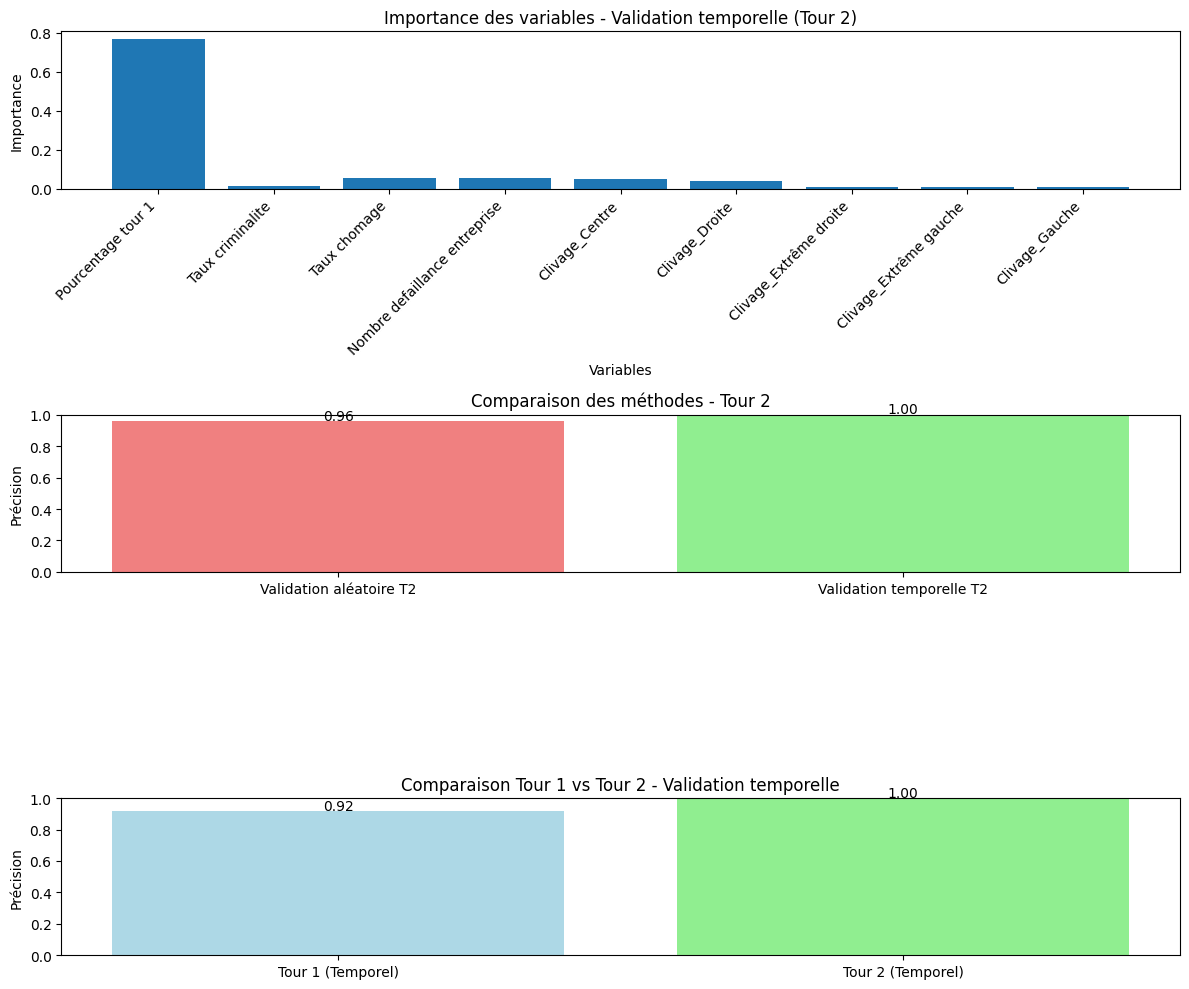

In [4]:
# Chargement des données
df = pd.read_csv("../fusioned_data/results_by_year.csv", sep=",")

# Encodage One-Hot pour 'Clivage'
one_hot = OneHotEncoder()
clivage_encoded = one_hot.fit_transform(df['Clivage'].values.reshape(-1,1)).toarray()
categories = one_hot.categories_[0]
clivage_df = pd.DataFrame(clivage_encoded, columns = ["Clivage_"+str(category) for category in categories])
df = pd.concat([df, clivage_df], axis=1)

# VALIDATION TEMPORELLE - Prédiction Tour 2
print("🎯 VALIDATION TEMPORELLE - Prédiction Tour 2")
print("="*50)

# Même approche temporelle pour le tour 2
train_years = [1995, 2002, 2007, 2012, 2017]
test_year = 2022

df_train_t2 = df[df['Année'].isin(train_years)]
df_test_t2 = df[df['Année'] == test_year]

# Sélection des caractéristiques (avec pourcentage tour 1)
feature_cols_t2 = ['Pourcentage tour 1', 'Taux criminalite', 'Taux chomage', 'Nombre defaillance entreprise'] + list(clivage_df.columns)
X_train_t2 = df_train_t2[feature_cols_t2]
y_train_t2 = df_train_t2['Gagnant tour 2']
X_test_t2 = df_test_t2[feature_cols_t2]
y_test_t2 = df_test_t2['Gagnant tour 2']

print(f"📚 Entraînement Tour 2 sur: {train_years} ({len(df_train_t2)} observations)")
print(f"🧪 Test Tour 2 sur: {test_year} ({len(df_test_t2)} observations)")

# Création et entraînement du modèle tour 2
model_temporal_t2 = RandomForestClassifier(random_state=42, n_estimators=100)
model_temporal_t2.fit(X_train_t2, y_train_t2)

# Prédiction et évaluation
y_pred_temporal_t2 = model_temporal_t2.predict(X_test_t2)
accuracy_temporal_t2 = accuracy_score(y_test_t2, y_pred_temporal_t2)

print(f"🎯 Précision validation temporelle Tour 2: {accuracy_temporal_t2:.2f}")

# Validation croisée temporelle pour le tour 2
print("\n🔄 VALIDATION CROISÉE TEMPORELLE - Tour 2")
print("="*50)

temporal_scores_t2 = []
for i in range(len(years)-1):
    train_years_cv = years[:i+4] if i+4 < len(years) else years[:i+3]
    if len(train_years_cv) < 3:
        continue
    
    test_year_cv = years[i+3] if i+3 < len(years) else years[-1]
    
    if test_year_cv in train_years_cv:
        continue
    
    df_train_cv_t2 = df[df['Année'].isin(train_years_cv)]
    df_test_cv_t2 = df[df['Année'] == test_year_cv]
    
    if len(df_test_cv_t2) == 0:
        continue
    
    X_train_cv_t2 = df_train_cv_t2[feature_cols_t2]
    y_train_cv_t2 = df_train_cv_t2['Gagnant tour 2']
    X_test_cv_t2 = df_test_cv_t2[feature_cols_t2]
    y_test_cv_t2 = df_test_cv_t2['Gagnant tour 2']
    
    model_cv_t2 = RandomForestClassifier(random_state=42, n_estimators=100)
    model_cv_t2.fit(X_train_cv_t2, y_train_cv_t2)
    
    y_pred_cv_t2 = model_cv_t2.predict(X_test_cv_t2)
    score_t2 = accuracy_score(y_test_cv_t2, y_pred_cv_t2)
    temporal_scores_t2.append(score_t2)
    
    print(f"📅 Entraînement: {train_years_cv} → Test: {test_year_cv} → Précision: {score_t2:.2f}")

# Comparaison avec validation aléatoire pour le tour 2
X_all_t2 = df[feature_cols_t2]
y_all_t2 = df['Gagnant tour 2']
X_train_random_t2, X_test_random_t2, y_train_random_t2, y_test_random_t2 = train_test_split(
    X_all_t2, y_all_t2, test_size=0.2, random_state=42)

model_random_t2 = RandomForestClassifier(random_state=42, n_estimators=100)
model_random_t2.fit(X_train_random_t2, y_train_random_t2)
y_pred_random_t2 = model_random_t2.predict(X_test_random_t2)
accuracy_random_t2 = accuracy_score(y_test_random_t2, y_pred_random_t2)

print(f"\n⚡ COMPARAISON TOUR 2")
print("="*30)
print(f"🎲 Précision validation aléatoire Tour 2: {accuracy_random_t2:.2f}")
print(f"🎯 Précision validation temporelle Tour 2: {accuracy_temporal_t2:.2f}")
if temporal_scores_t2:
    print(f"📈 Précision moyenne validation croisée Tour 2: {np.mean(temporal_scores_t2):.2f} ± {np.std(temporal_scores_t2):.2f}")

# Importance des variables Tour 2
importances_t2 = model_temporal_t2.feature_importances_
feature_names_t2 = X_train_t2.columns

print(f"\n🔍 IMPORTANCE DES VARIABLES Tour 2 (Modèle temporel)")
print("="*50)
for feature_name, importance in zip(feature_names_t2, importances_t2):
    print(f"{feature_name.replace('Clivage_', '')}: {importance:.4f}")

# Visualisation Tour 2
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.bar(feature_names_t2, importances_t2)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Variables')
plt.ylabel('Importance')
plt.title('Importance des variables - Validation temporelle (Tour 2)')

plt.subplot(3, 1, 2)
methods = ['Validation aléatoire T2', 'Validation temporelle T2']
scores_t2 = [accuracy_random_t2, accuracy_temporal_t2]
colors = ['lightcoral', 'lightgreen']
plt.bar(methods, scores_t2, color=colors)
plt.ylabel('Précision')
plt.title('Comparaison des méthodes - Tour 2')
plt.ylim(0, 1)
for i, score in enumerate(scores_t2):
    plt.text(i, score + 0.01, f'{score:.2f}', ha='center')

plt.subplot(3, 1, 3)
# Comparaison Tour 1 vs Tour 2
tours = ['Tour 1 (Temporel)', 'Tour 2 (Temporel)']
scores_comparison = [accuracy_temporal, accuracy_temporal_t2]
colors_comparison = ['lightblue', 'lightgreen']
plt.bar(tours, scores_comparison, color=colors_comparison)
plt.ylabel('Précision')
plt.title('Comparaison Tour 1 vs Tour 2 - Validation temporelle')
plt.ylim(0, 1)
for i, score in enumerate(scores_comparison):
    plt.text(i, score + 0.01, f'{score:.2f}', ha='center')

plt.tight_layout()
plt.show()

## 📝 Conclusions et Bonnes Pratiques

### ❌ **Problèmes de la validation aléatoire**
1. **Data leakage** : Le modèle peut s'entraîner sur des données futures et être testé sur le passé
2. **Irréaliste** : Ne simule pas une vraie situation de prédiction
3. **Scores surestimés** : Donne une confiance excessive dans le modèle

### ✅ **Avantages de la validation temporelle**
1. **Réaliste** : Simule une vraie prédiction (passé → futur)
2. **Pas de data leakage** : Respecte l'ordre chronologique
3. **Scores fiables** : Évaluation honnête des performances

### 🎯 **Recommandations pour ce type de projet**

#### **Pour les données temporelles :**
- ✅ Toujours utiliser une validation temporelle
- ✅ Entraîner sur le passé, tester sur le futur
- ✅ Utiliser plusieurs années d'entraînement si possible
- ✅ Tester sur plusieurs années futures (validation croisée temporelle)

#### **Pour améliorer le modèle :**
- 📊 Ajouter plus de variables socio-économiques
- 🗺️ Inclure des variables géographiques/régionales  
- 👥 Intégrer des données démographiques
- 📈 Utiliser des tendances temporelles (évolution des indicateurs)

#### **Métriques à considérer :**
- 🎯 Précision par année de test
- 📊 Matrice de confusion pour chaque classe
- 🔍 Analyse des erreurs par département/région
- 📈 Évolution des performances dans le temps

### ⚠️ **Attention aux biais**
- Les patterns électoraux évoluent dans le temps
- Certains événements peuvent changer les tendances
- Un modèle entraîné sur trop peu d'années peut être fragile

---

**💡 Conseil** : Pour une vraie prédiction 2027, utilisez toutes les données 1995-2022 pour l'entraînement et appliquez le modèle sur les nouvelles données socio-économiques de 2027.